In [1]:
%matplotlib inline
import random
import numpy as np
from torch.autograd import Variable
import time
from skimage.feature import greycomatrix
import cv2
from enum import IntEnum
from matplotlib import pyplot as plt

# for optimization step2~step3 (tensor autograd)
from sympy import *
from scipy.misc import derivative
import math
import torch

import pickle

In [2]:
!pip install numpngw
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Step0: Preprocessing:
  1)superpixel;
  
  2)Fundamental Matrix;
  
  3)Semantic Segmentation

In [3]:
#################################################
## 1) superpixel
#################################################
def calcSuperPixel(img1, img2):
  #初始化slic项，超像素平均尺寸20（默认为10），平滑因子20
  slic = cv2.ximgproc.createSuperpixelSLIC(img1,region_size=20,ruler = 20.0)
  slic.iterate(10)     # higher iterations, better performance
  mask_slic = slic.getLabelContourMask() #获取Mask，超像素边缘Mask==1

  # superpixel results
  label_slic = slic.getLabels()        #获取超像素标签
  number_slic = slic.getNumberOfSuperpixels()  #获取超像素数目

  return label_slic, number_slic

In [4]:
#################################################
## 2) Fundamental Matrix
#################################################
def calcFundamentalMatrix(img1, img2):
  orb = cv2.ORB_create()

  # find the keypoints and descriptors with orb
  kp1, des1 = orb.detectAndCompute(img1,None)
  kp2, des2 = orb.detectAndCompute(img2,None)

  # create BFMatcher object
  bf = cv2.BFMatcher(cv2.NORM_HAMMING2, crossCheck=True)
  # Match descriptors.
  matches = bf.match(des1,des2)
  # Sort them in the order of their distance.
  #matches = sorted(matches, key = lambda x:x.distance)

  pts1 = []
  pts2 = []

  for i,(m) in enumerate(matches):
      if m.distance < 50:           # may need to change
          pts2.append(kp2[m.trainIdx].pt)
          pts1.append(kp1[m.queryIdx].pt)
  pts1 = np.asarray(pts1)
  pts2 = np.asarray(pts2)
  F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC, 1, 0.99)
  return F

In [5]:
#################################################
## 3) Semantic Segmentation
#################################################
# import and process the segmentation images:
def calcSemanticSegmentation(seg1_gray, seg2_gray):
  seg1_carmask = np.zeros((seg1_gray.shape[0], seg1_gray.shape[1])) # mask of car: 375*1242 
  for i in range(seg1_carmask.shape[0]):
      for j in range(seg1_carmask.shape[1]):
          if(seg1_gray[i][j][0] == 176):
              seg1_carmask[i][j] = 1
          else:
              seg1_carmask[i][j] = 0
  seg2_carmask = np.zeros((seg2_gray.shape[0], seg2_gray.shape[1])) # mask of car: 375*1242 
  for i in range(seg2_carmask.shape[0]):
    for j in range(seg2_carmask.shape[1]):
        if(seg2_gray[i][j][0] == 176):
            seg2_carmask[i][j] = 1
        else:
            seg2_carmask[i][j] = 0
  return seg1_carmask, seg2_carmask

### Step1: Energy Definition

In [6]:
def calc_ED(H, Super_s_O,image, image_next,this_sp):
    """
    Color Data term:
    Aggregate photometric differences
    
    Input:
    H: 3X3 homograpy matrix between 2 timeframes I_t and I_t+1
    Super_s_O: matrix of a superpixel occlusion mask o, and shape equals to superpixel shape

    Output:
    calc_ED: a float value 
    """    

    superpixel_size = np.shape(this_sp)[0]   #number of pixel in a superpixel
    res_ED = 0.0
    (height, width) = image.shape

    #####################################
    ## slow version
    #####################################
    # for index in range(superpixel_size):
    #     i, j=this_sp[index]
    #     p=np.array([i,j,1])
    #     temp = H@p
    #     temp /=temp[2]   
    #     i_prime=min(max(np.around(temp[0]).astype(int), 0), height-1)
    #     j_prime=min(max(np.around(temp[1]).astype(int), 0), width-1)
    #     res_ED += (1 - Super_s_O[i][j])*(image[i][j] - image_next[i_prime][j_prime]) + Super_s_O[i][j]*lambda_o

    # res_ED /= superpixel_size
    
    #####################################
    ## optimized fast version
    #####################################
    # homo_axis = np.ones( (np.shape(this_sp)[0], 1), dtype="int" )
    # p = np.concatenate((this_sp, homo_axis), axis=1)
    # p_prime_unnorm = (H@p.transpose()).transpose()
    # p_prime = p_prime_unnorm/(p_prime_unnorm[:,-1])[:,None]

    # for idx in range(superpixel_size):
    #   i, j=this_sp[idx]
    #   i_prime=min(max(np.around(p_prime[idx][0]).astype(int), 0), height-1)
    #   j_prime=min(max(np.around(p_prime[idx][1]).astype(int), 0), width-1)
    #   res_ED += (1 - Super_s_O[i][j])*(image[i][j] - image_next[i_prime][j_prime]) + Super_s_O[i][j]*lambda_o
    # res_ED /= superpixel_size

    #####################################
    ## even faster version (28s/iteration)
    #####################################
    # homo_axis = np.ones( (np.shape(this_sp)[0], 1), dtype="int" )
    # p = np.concatenate((this_sp, homo_axis), axis=1)
    # p_prime_unnorm = (H@p.transpose()).transpose()
    # p_prime = p_prime_unnorm/(p_prime_unnorm[:,-1])[:,None]

    # for idx in range(superpixel_size):
    #   i, j=this_sp[idx]
    #   i_prime=min(max(np.floor(p_prime[idx][0]).astype(int), 0), height-1)
    #   j_prime=min(max(np.floor(p_prime[idx][1]).astype(int), 0), width-1)
    #   res_ED += (1 - Super_s_O[i][j])*(image[i][j] - image_next[i_prime][j_prime]) + Super_s_O[i][j]*lambda_o

    # res_ED /= superpixel_size

    #####################################
    ## The fastest version ever
    #####################################
    homo_axis = np.ones( (np.shape(this_sp)[0], 1), dtype="int" )
    p = np.concatenate((this_sp, homo_axis), axis=1)
    p_prime_unnorm = (H@p.transpose()).transpose()
    p_prime = p_prime_unnorm/(p_prime_unnorm[:,-1])[:,None]
    this_sp_trans = this_sp.transpose()

    a = Super_s_O[tuple(this_sp_trans)]
    b = image[tuple(this_sp_trans)]
    i_prime = np.minimum( height-1 ,np.maximum(0, np.floor(p_prime[:,0]).astype(int)))  # array of Nx2
    j_prime = np.minimum( width-1  ,np.maximum(0, np.floor(p_prime[:,1]).astype(int)))  # array of Nx2
    c = image_next[i_prime, j_prime]

    res_ED = ( (1-a).transpose() @ (b-c) + lambda_o*np.sum(a)) / superpixel_size

    return res_ED

def calc_EL(H, Super_s_O, L_t, L_t_next, L_hat_t_next,this_sp):
    """
    Label Data term:
    penalize label differences to the bottom-up evidence and at the same time propagate label evidence over time.
    
    Input:
    L_t: row_image*col_image*class semantic label probability distribution matrix at time t; weighted sum of the previous estimation
    L_t_next: row_image*col_image*class semantic label probability distribution matrix at time t+1
    L_hat_t_next: row_image*col_image*class bottom-up evidence
    
    Output:
    calc_EL: A float value
    """
    #####################################
    ## slow version
    #####################################
    # res_EL = 0.0
    # superpixel_size = np.shape(this_sp)[0]
     
    # for index in range(superpixel_size):
    #   i, j=this_sp[index]
    #   phi_l = 0.5*(1 - Super_s_O[i][j])*(L_t_next[i][j] - (alpha*L_hat_t_next[i][j] + (1 - alpha)*L_t[i][j]))**2
    #   res_EL += phi_l
                                               
    # res_EL /= superpixel_size
    
    #####################################
    ## optimized fast version
    #####################################
    superpixel_size = np.shape(this_sp)[0]
    this_sp_trans = this_sp.transpose()

    a = Super_s_O[tuple(this_sp_trans)]
    b = L_t_next[tuple(this_sp_trans)]
    c = L_hat_t_next[tuple(this_sp_trans)]
    d = L_t[tuple(this_sp_trans)]
    e = (b-alpha*c-(1-alpha)*d) * (b-alpha*c-(1-alpha)*d)

    res_EL = 0.5*(1-a).reshape(1,-1) @ e.reshape(-1,1) / superpixel_size
    return res_EL

def calc_EP(H, this_sp, F, L_t):
    """
    Physical Constraint term:
    measures how well te homography matrix Hs of a superpixel s meets the epipolar constraint form the fundamental matrix F
    
    Input:
    H: Homography matrix Hs
    F: Fundamental matrix
    Super_s_t: superpixel matrix at timeframe I_t
    L_t: row_image*col_image*1 semantic label probability distribution matrix at time t 
    
    Output:
    calc_EP: A float value
    
    """
    tunning_comparision = lambda_non_st 
    
    phi = 0.0   #first term of min function
    superpixel_size = np.shape(this_sp)[0]  #number of pixels in this superpixel

    ############################Optimization Start##############################
    #####################################
    ## slow version
    #####################################
    # new_lt=[None] * superpixel_size
    # for i in range(superpixel_size):
    #       p = np.array(this_sp[i])
    #       p = p.transpose()
    #       p = np.append(p,1)
    #       temp = H@p
    #       temp /=temp[2]   
    #       temp2 = temp.transpose()@F@p
    #       phi += np.linalg.norm(temp2)
    #       new_lt.append(L_t[this_sp[i][0]][this_sp[i][1]])
  
    # phi /= superpixel_size

    #####################################
    ## fast optimized version
    #####################################
    # new_lt=[None] * superpixel_size
    # homo_axis = np.ones( (np.shape(this_sp)[0], 1), dtype="int" )
    # p = np.concatenate((this_sp, homo_axis), axis=1)
    # p_prime_unnorm = (H@p.transpose()).transpose()
    # p_prime = p_prime_unnorm/(p_prime_unnorm[:,-1])[:,None]
    
    # p_transpose = p.transpose()
    # for i in range(superpixel_size):
    #   phi += np.abs(p_prime[i,:] @ F @ p_transpose[:,i] )
    #   new_lt[i] = (L_t[this_sp[i][0]][this_sp[i][1]])

    # phi /= superpixel_size
    
    #####################################
    ## even faster optimized version
    #####################################
    # new_lt=[None] * superpixel_size
    # homo_axis = np.ones( (np.shape(this_sp)[0], 1), dtype="int" )
    # p = np.concatenate((this_sp, homo_axis), axis=1)
    # p_prime_unnorm = (H@p.transpose()).transpose()
    # p_prime = p_prime_unnorm/(p_prime_unnorm[:,-1])[:,None]
    
    # phi = np.sum((p_prime @ F) * p)
    # phi /= superpixel_size

    # for i in range(superpixel_size):
    #   new_lt[i] = (L_t[this_sp[i][0]][this_sp[i][1]])
    
    #####################################
    ## fastest optimized version ever
    #####################################
    new_lt=[None] * superpixel_size
    homo_axis = np.ones( (np.shape(this_sp)[0], 1), dtype="int" )
    p = np.concatenate((this_sp, homo_axis), axis=1)
    p_prime_unnorm = (H@p.transpose()).transpose()
    p_prime = p_prime_unnorm/(p_prime_unnorm[:,-1])[:,None]
    
    phi = np.sum((p_prime @ F) * p)
    phi /= superpixel_size

    i = this_sp[:,0]
    j = this_sp[:,1]
    new_lt = (L_t[i,j]).astype(int)
    ############################################################################

    #l_st: get the representative semantic label of superpixel
    l_st = np.bincount(new_lt).argmax()
    
    # calculate the second variable for comparison
    if l_st==0 : tunning_comparision = lambda_non_st + beta
    
    calc_EP = min(phi, tunning_comparision)
    
    return calc_EP


def get_this_superpixel(superpixelmap,index):
  '''
  #0 for background
  #1 for car
  '''
  res = np.where(superpixelmap == index)
  this_sp = np.concatenate( (res[0].reshape(-1,1), res[1].reshape(-1,1)), axis=1)

  return this_sp     #n by 2 matrix

def get_totalE(H, F, Super_s_O, image, image_next, superpixelmap, index, L_t, L_t_next, L_hat_t_next):
  this_sp = get_this_superpixel(superpixelmap, index)
  Ed = calc_ED(H, Super_s_O, image, image_next, this_sp)
  El = calc_EL(H, Super_s_O, L_t, L_t_next, L_hat_t_next,this_sp)
  Ep = calc_EP(H, this_sp, F, L_t)
  totalE=Ed+lamda_l*El+lamda_p*Ep

  return totalE

### Step2: PMBP Definition

In [7]:
#################################################
## 0.preparation
#################################################
class View(IntEnum):
  IMAGE_ONE = 0
  IMAGE_TWO = 1

#################################################
## 1.class State [H: homography]
#################################################
class StateWeight:    # Particle
  def __init__(self, H_param, weight):
    self.H_param = H_param   # [theta, Tx, Ty, Sx, Sy, P1, P2]
    self.H = self.ParameterizationToH(self.H_param)
    self.weight = weight

  def GetStateParam(self):
    return self.H_param
  
  def GetWeight(self):
    return self.weight
  
  def GetState(self):
    # self.UpdateH(self.H_param)
    return self.H
  
  # update H simultaneously
  def UpdateParameterization(self, param):
    self.H_param = param
    self.H = self.ParameterizationToH(param)
  
  def ParameterizationToH(self, param):
    theta, Tx, Ty, Sx, Sy, P1, P2 = param
    He = np.array([[np.cos(theta), -np.sin(theta), Tx],[np.sin(theta), np.cos(theta), Ty],[0,0,1]]);
    Ha = np.array([[1, Sy, 0],[Sx, 1, 0],[0,0,1]])
    Hp = np.array([[1,0,0],[0,1,0],[P1,P2,1]])
    return He@Ha@Hp

  def UpdateH(self, param):
    theta, Tx, Ty, Sx, Sy, P1, P2 = param
    He = np.array([[np.cos(theta), -np.sin(theta), Tx],[np.sin(theta), np.cos(theta), Ty],[0,0,1]]);
    Ha = np.array([[1, Sy, 0],[Sx, 1, 0],[0,0,1]])
    Hp = np.array([[1,0,0],[0,1,0],[P1,P2,1]])
    self.H = He@Ha@Hp

#################################################
## 2.class Node [attached with each superpixel]
#################################################
class Node:
  def __init__(self, size):
    self.particles = []
    for i in range(size):
      randParam = np.zeros(7)     # 0 Homography Parameterization
      randWeight = np.zeros(1)    # 0 Average distr.
      self.particles.append( StateWeight(randParam, randWeight) );
    
    self.foundations = []         # Initialized in InitialiseFields(view)
    self.neighborLabel_dirIdx = {}

  def GetSize(self):
    return len(self.particles)

  def SetParticle(self, ptcl_no, state_param, value):
    self.particles[ptcl_no].UpdateParameterization(state_param)
    self.particles[ptcl_no].weight = value

  def SetParticleValue(self, ptcl_no, value):
    self.particles[ptcl_no].weight = value

  def GetDisbelief(self, ptcl_no):
    return self.particles[ptcl_no].weight

  def GetMaxValue_ParticleIdx(self):
    idx = 0
    max_value = self.particles[0].weight
    for i, ptc in enumerate(self.particles):
      if ptc.weight > max_value:
        idx = i
        max_value =  ptc.weight
    return idx, max_value

  def GetMinValue_ParticleIdx(self):
    idx = 0
    min_value = self.particles[0].weight
    for i, ptc in enumerate(self.particles):
      if ptc.weight < min_value:
        idx = i
        min_value = ptc.weight
    return idx, min_value
  
  def GetMaxParticle(self):
    '''
    'Particle' is also known as 'StateWeight': pair{H, float}
    '''
    idx = 0
    max_value = self.particles[0].weight
    for i, ptc in enumerate(self.particles):
      if ptc.weight > max_value:
        idx = i
        max_value =  ptc.weight
    return self.particles[idx]

  def GetMinParticle(self):
    '''
    'Particle' is also known as 'StateWeight': pair{H, float}
    '''
    idx = 0
    min_value = self.particles[0].weight
    for i, ptc in enumerate(self.particles):
      if ptc.weight < min_value:
        idx = i
        min_value = ptc.weight

    return self.particles[idx]

  def GetParticle(self, k):
    return self.particles[k]
    
  def SetFoundation(self, neighborLabel, k, value):
    dirIdx = self.neighborLabel_dirIdx[str(neighborLabel)]
    self.foundations[dirIdx][k] = value

  def GetFoundationValue(self, neighborLabel, k):
    dirIdx = self.neighborLabel_dirIdx[str(neighborLabel)]
    return self.foundations[dirIdx][k]

  def NormalizeFoundation(self, neighbor):
    idx = self.neighborLabel_dirIdx[str(neighbor)]
    foundation_sum = 0
    foundation_size = len(self.foundations[idx])
    for value in self.foundations[idx]:
      foundation_sum += value
    if foundation_sum != 0:
      constant = 0
      rest = (foundation_sum - constant) / foundation_size
      for k,value in enumerate(self.foundations[idx]):
        self.foundations[idx][k] -= rest

#################################################
## 3.class Parameters
#################################################
class Parameters:
  def __init__(self,
               n_iterations,
               super_pix_num,
               output_dir,
               n_particles,
               bidirectional = False):
    self.super_pix_num = super_pix_num
    self.n_iterations = n_iterations
    self.output_dir = output_dir
    self.n_particles = n_particles
    self.bidirectional = bidirectional

#################################################
## 4.class SuperPixel
#################################################
class SuperPixel:
  def __init__(self, supImg, num_super):
    self.supImg = supImg    # SuperPixel Image
    self.num_super = num_super  # how many super pixels in total
    
    comatrix_set = greycomatrix(supImg, [1], [0, np.pi/2], levels=num_super, symmetric=True)
    initial_comatrix = comatrix_set[:, :, 0, 0] + comatrix_set[:, :, 0, 1].transpose()
    self.comatrix = initial_comatrix-np.diag(np.diag(initial_comatrix)) # set 0 to diag place

  def GetNeighborSuperPixel(self, supLabel):
    #################################################
    ## slow version
    #################################################
    # neighborSupLabel = []
    # for i, x in enumerate(self.comatrix[supLabel]):
    #   if x != 0:
    #     neighborSupLabel.append(i);
    # return neighborSupLabel
    #################################################
    ## fast version
    #################################################
    idx = np.where( self.comatrix[supLabel] != 0 )
    neighborSupLabel = idx[0].tolist()
    return neighborSupLabel

  def GetInsidePixel(self, superPixelNo):
    pixelCoord = np.argwhere(self.supImg == superPixelNo)
    return pixelCoord   # 'Nx2' array


#################################################
## 5.class OpticalFlowSemantics
#################################################
class OpticalFlowSemantics:
  def __init__( self,
                supImg,
                parameters,
                F,
                L_t,                      # bottom-up semantics at time t
                L_hat_t_next,             # bottom-up semantics at time t+1
                mask_o,
                mask_b,
                image1,
                image2 ):
    self.parameters = parameters
    self.nodes = [ [Node(self.parameters.n_particles) for i in range(self.parameters.super_pix_num)] for k in range(2)]
    self.processed = [ [False for i in range(self.parameters.super_pix_num) ] for k in range(2)]
    self.propagated =[ [False for i in range(self.parameters.super_pix_num) ] for k in range(2)]
    self.superpixel = SuperPixel(supImg, self.parameters.super_pix_num)
    self.INFINITY = 1e10

    self.F = F                            # Fundamental Matrix
    self.L_t = L_t
    self.L_hat_t_next = L_hat_t_next
    self.L_t_next = L_hat_t_next          # use the estimated bottom-up semantics info to initialize the actual value
    self.mask_o = mask_o
    self.mask_b = mask_b
    self.image1 = image1
    self.image2 = image2

    # initialization
    self.InitialiseNodes(View.IMAGE_ONE)
    # print("checkpoint1: Initialization Finished")

  def SetProcessed(self, view, index, isSet=False):
    self.processed[view][index] = isSet

  def IsProcessed(self, view, index):
    return self.processed[view][index]

  def SetPropagated(self, view, index, isSet=False):
    self.propagated[view][index] = isSet

  def IsPropagated(self, view, index):
    return self.propagated[view][index]

  # --------State Related Methods--------
  def GetRandomStateParam(self):
    '''
    Random H_param = [theta, Tx, Ty, Sx, Sy, P1, P2]
    '''
    theta = np.random.rand()*2*np.pi # 0~2Pi
    Tx = np.random.rand()*2-1 # -1.0~1.0
    Ty = np.random.rand()*2-1 # -1.0~1.0
    Sx = np.random.rand()*2-1 # -1.0~1.0
    Sy = np.random.rand()*2-1 # -1.0~1.0
    P1 = np.random.rand()*2-1 # -1.0~1.0
    P2 = np.random.rand()*2-1 # -1.0~1.0

    H_param = [theta, Tx, Ty, Sx, Sy, P1, P2]
    return H_param

  # --------Initialization--------
  def InitialiseNodes(self, view):
    '''
    Description:
      initialize self.nodes[view][...].particles[] as [{random_state, 0}] * n_particles
      initialize self.nodes[view][...].foundations[] as [ [0 0...0]*{n_particle}] * number_of_neighbors
    Note:
      1) If image1's the node 'origin' has a 'neighbor', kth particle, then the corresponding foundation is:
          idx = self.nodes[view][i].neighborLabel_dirIdx[str(neighbor)]
          foundation = self.nodes[view][origin].foundations[idx][k]
    '''
    # initialize self.nodes.particles = [{random_state, 0}] * n_particles
    for i in range(self.parameters.super_pix_num):
      for k in range(self.parameters.n_particles):
        state_param = self.GetRandomStateParam()
        self.nodes[view][i].SetParticle(k,state_param,0)
    
    # initialize self.nodes.foundations = [ [0 0...0]*{n_particles}] * number_of_neighbors
    for i in range(self.parameters.super_pix_num):
      neighbor_list = self.superpixel.GetNeighborSuperPixel(i)  # return a list of super label

      for j, neighborLabel in enumerate(neighbor_list):
        self.nodes[view][i].neighborLabel_dirIdx[str(neighborLabel)] = j
        self.nodes[view][i].foundations.append( [0] * self.parameters.n_particles )
          
  # It has been absorbed into the __init__(): def InitialiseFields(self, view)
  
  # --------Solve Optical FLow--------
  def solve(self):
    '''
    Using PMBP to optimize for the best 'H' iteratly.
    The results are stored in self.nodes[view][...].particles[]
    Symbols:
      self.nodes[view][...]: stand for a Node, also known as 'superpixel'
      self.nodes[view][...].particles[]: "StateWeight" attached with each superpixel, with total number of {n_particles}
    '''    
    # solve iteration: 0~n_iterations
    for i in range(self.parameters.n_iterations):
      # iterate and time counting
      time_start=time.time()
      self.Iterate(i)
      time_end=time.time()

      print("Iteration: %d" % (i))
      print('Iteration time cost: ',time_end-time_start,'s')
      print("---------------------------------------------------")

  def Iterate(self, it):
    self.IterateView(it, View.IMAGE_ONE)
    self.ResetProcess() # reset processed[] Mask every iteration

  def IterateView(self, it, view):
    dict_iter = self.GetDirections(it, view)
    for i in range(dict_iter['i_first'], dict_iter['i_last'], dict_iter['i_incr']):
      # Pulls the messages
      # print("checkpoint2: UpdateCurrentDisbelief Start")
      self.UpdateCurrentDisbelief(view, i)
      
      # Update particles
      # print("checkpoint3, iteration: %d: Update Start" % (i))
      self.Update(view, i)

      # Cache new foundations [In the end: self.SetProcessed(view, i, isSet=True)]
      # print("checkpoint4: Cache Start")
      self.Cache(view, i)

  def GetDirections(self, it, view):
    '''
    Description:
      Decide the visiting sequence of superpixels
    '''
    dict_iter = dict({})
    if it%2 == 0:
      dict_iter['i_first'] = 0
      dict_iter['i_last'] = self.parameters.super_pix_num
      dict_iter['i_incr'] = 1
    else:
      dict_iter['i_first'] = self.parameters.super_pix_num-1
      dict_iter['i_last'] = -1
      dict_iter['i_incr'] = -1
    return dict_iter

  def ResetProcess(self):
    # reset Image2's processed mask
    if self.parameters.bidirectional:
      for i in range(len(self.processed[View.IMAGE_TWO])):
        self.processed[View.IMAGE_TWO][i] = False
    
    # reset Image1's processed mask
    for i in range(len(self.processed[View.IMAGE_ONE])):
      self.processed[View.IMAGE_ONE][i] = False
  
  # --------InterateView related methods--------
  def UpdateCurrentDisbelief(self, view, i):
    '''
    Input:
      view: image1 or image2
      i: origin node
    Description:
      update every particle's "Disbelief" inside the origin node
      however, particle's state doesn't change
    '''
    num_ptc = self.nodes[view][i].GetSize()
    for k in range(num_ptc):
      particle = self.nodes[view][i].GetParticle(k)
      self.nodes[view][i].SetParticleValue(k, self.EvaluateDisbelief(view, i, particle))

  # --------Candidate state generation--------
  # UpdateCurrentDisbelief --> EvaluateDisbelief
  def EvaluateDisbelief(self, view, i, particle, early_termination=False):
    '''
    Input:
      i: origin node
      k: origin node's particle index
    Description:
      Iterate over neighbors;
      EvaluateMessage returns the minimum combined energy (pairwise_energy+foundation)
      for each neighbor. Accumulate them all
      one {origin, particle} --> one unary energy
    '''
    neighbor_list = self.superpixel.GetNeighborSuperPixel(i)
    message_sum = 0.0
    for j, neighborSuperLabel in enumerate(neighbor_list):
      message_sum += self.EvaluateMessage(view, i, neighborSuperLabel, particle)
    
    # Unary Energy [implemented]
    H = particle.GetState()
    index = i
    unary_energy = self.UnaryEnergy(view, H, index)

    return unary_energy + message_sum

  def EvaluateMessage(self, view, origin, neighbor, particle):
    '''
    Description:
      1)For each node 'origin', and the corresponding particle 'origin_k', and a specific 'neighbor';
        We iterate the neighbor's particles.
      2)Neighbor decides the direction of foundations;
        neighbor_k decides the message index of foundations[direction][neighbor_k]
    
    Output:
      Return the minimum 'pairwise_energy + foundation'
    '''
    value = self.INFINITY
    for neighbor_k in range( self.nodes[view][origin].GetSize() ): # iterate over node origin's particles
      pairwise_energy = self.PairwiseEnergy(view, origin, particle, neighbor, neighbor_k) # one particle of origin, one energy
      foundation = self.nodes[view][origin].GetFoundationValue(neighbor, neighbor_k)
      current = pairwise_energy + foundation
      if current < value:
        value = current
    
    # return the minimun energy
    return value

  # --------------------------------------------------------------
  def Update(self, view, i):
    '''
    Input:
      view: image1 or image2
      i: origin node
    Description:
      UPDATE all the particles inside a node
    '''
    # 1) propagate from all the neighbours
    # print("---checkpoint5: Propagate Start")
    self.Propagate(view, i)
    # 2) random search
    # print("---checkpoint6: Randomize Start")
    self.Randomize(view, i)

  def Propagate(self, view, origin):
    '''
    Description:
      iterate over all the neighbors, and to see...
      if the neighbor's particles could help substitute the origin's highest-energy particle
    '''
    neighbor_list = self.superpixel.GetNeighborSuperPixel(origin)
    for neighbor in neighbor_list:
      if self.IsProcessed(view, neighbor):
        neighbor_min_particle = self.GetParticleFromNeighbor(view, neighbor)
        self.ProposeCandidate(view, origin, neighbor_min_particle)

  # Update --> Propagate --> GetStateFromNeighbor
  def GetParticleFromNeighbor(self, view, neighbor):
    '''
    Description:
      get minimum particle from a neighbor
    Return:
      neighbor node's particle with minimum energy
    '''
    return self.nodes[view][neighbor].GetMinParticle()

  # Update --> Propagate --> ProposeCandidate
  def ProposeCandidate(self, view, origin, particle):
    '''
    Description:
      if the neighbor's particles could help substitute the origin's highest-energy particle
    '''
    max_idx, max_value = self.nodes[view][origin].GetMaxValue_ParticleIdx()
    B = self.EvaluateDisbelief(view, origin, particle, False)

    if B<max_value:
      self.SetPropagated(view, origin, True)
      self.nodes[view][origin].SetParticle(max_idx, particle.GetStateParam() ,B)

  def Randomize(self, view, origin):
    '''
    Description:
      update the node {nodes[view][origin]}'s particles by generating random particles
    '''
    # for k in range(self.nodes[view][origin].GetSize()):
    k = np.random.randint(self.nodes[view][origin].GetSize())
    ratio = 0.1
    origin_particle = self.nodes[view][origin].GetParticle(k)
    while ratio > 0.01:
      # print("------checkpoint7:GetRandomParticleAround start")
      random_particle = self.GetRandomParticleAround(view, origin, origin_particle, ratio)
      # print("------checkpoint8:ProposeCandidate start")
      self.ProposeCandidate(view, origin, random_particle)
      ratio /= 2

  # Update --> Randomize --> GetRandomStateAround {GetRandomParticleAround}
  def GetRandomParticleAround(self, view, origin, origin_particle, ratio):
    '''
    Description:
      get a new state
    '''
    max_drift = ratio
    max_angle = ratio * np.pi
    theta, Tx, Ty, Sx, Sy, P1, P2  = origin_particle.GetStateParam()
    delta_theta = (np.random.rand()*2-1)*max_angle  # -Pi~Pi * max_angle
    delta_Tx = (np.random.rand()*2-1) * max_drift   # -1.0~1.0
    delta_Ty = (np.random.rand()*2-1) * max_drift   # -1.0~1.0
    delta_Sx = (np.random.rand()*2-1) * max_drift   # -1.0~1.0
    delta_Sy = (np.random.rand()*2-1) * max_drift   # -1.0~1.0
    delta_P1 = (np.random.rand()*2-1) * max_drift   # -1.0~1.0
    delta_P2 = (np.random.rand()*2-1) * max_drift   # -1.0~1.0

    new_param  = [theta+delta_theta, Tx+delta_Tx, Ty+delta_Ty, Sx+delta_Sx, Sy+delta_Sy, P1+delta_P1, P2+delta_P2]
    new_particle = StateWeight(new_param, 0)
    return new_particle
  
  # --------------------------------------------------------------
  def Cache(self, view, origin):
    '''
    Input:
      origin: origin node
    Description:
      We update the cached foundations here
    '''
    # iterate over node i's particles
    for k in range(self.nodes[view][origin].GetSize()):
      particle = self.nodes[view][origin].GetParticle(k)
      d = self.nodes[view][origin].GetDisbelief(k)
      neighbor_list = self.superpixel.GetNeighborSuperPixel(origin)
      # fix k th particle, iterate over neighbors
      # for i, neighbor in enumerate(random.sample(neighbor_list, min(4, len(neighbor_list))) ): # choose at most 4 neighbors randomly [for simplification]
      for i, neighbor in enumerate(neighbor_list): # choose at most 4 neighbors randomly
        m = self.EvaluateMessage(view, origin, neighbor, particle)
        v = m - d
        self.nodes[view][origin].SetFoundation(neighbor, k, v)
        self.nodes[view][origin].NormalizeFoundation(neighbor)
    
    # Reset Processed Mask
    self.SetProcessed(view, i, isSet=True)

  # --------Energy Evaluation--------
  # to be implemented by wang & weng
  def UnaryEnergy(self, view, H, index):
    '''
    Usage:
      def get_totalE(H, F, Super_s_O, image, image_next, superpixelmap, index, L_t, L_t_next, L_hat_t_next)
    '''
    return get_totalE(H, self.F, self.mask_o, self.image1, self.image2, self.superpixel.supImg, index, self.L_t, self.L_t_next, self.L_hat_t_next)

  def PairwiseEnergy(self, view, origin, particle, neighbor, neighbor_k):
    '''
    we don't consider the PairwiseEnergy for now
    '''
    return 0

### Step3: Gradient Optimization Definition

In [8]:
def calc_ED_tensor(H, spixel_s_O, image, image_next,this_sp):

    """
    Color Data term:
    Aggregate photometric differences
    
    All inputs and outputs are tensors the dtype is float64
    
    Input: 
    H: 3X3 homograpy matrix between 2 timeframes I_t and I_t+1
    Super_s_O: matrix of a superpixel occlusion mask o, and shape equals to superpixel shape

    
    Output:
    calc_ED_tensor: a float value 
    
    """    

    superpixel_size = list(this_sp.shape)[0]   #number of pixel in a superpixel
    res_ED = torch.tensor(0.0)
            
    for index in range(superpixel_size):
        i=this_sp[index][0].int()
        j=this_sp[index][1].int()
        p = torch.tensor([i,j,1],dtype = torch.float)
        
        temp = H@p
        temp[0] = temp[0]/temp[2]   
        temp[1] = temp[1]/temp[2]
        temp[2] = temp[2]/temp[2]
        i_prime_unnorm = (temp[0].round()).int() # what if over the boundary? 
        j_prime_unnorm = (temp[1].round()).int()
        i_prime = np.minimum( height-1 , np.maximum(0, i_prime_unnorm) )
        j_prime = np.minimum( width-1  , np.maximum(0, j_prime_unnorm) )
        #res_ED += (1 - Super_s_O[i][j])*(image[i][j] - image_next[i_prime][j_prime]) + Super_s_O[i][j]*lambda_o
        res_ED += (1 - spixel_s_O[index])*(image[i][j] - image_next[i_prime][j_prime]) + spixel_s_O[index]*lambda_o
    res_ED = res_ED/superpixel_size

    return res_ED

def calc_EL_tensor(H, spixel_s_O, L_t, spixel_L_t_next, L_hat_t_next,this_sp):
    """
    Label Data term:
    penalize label differences to the bottom-up evidence and at the same time propagate label evidence over time.
    
    Input:
    L_t: row_image*col_image*class semantic label probability distribution matrix at time t; weighted sum of the previous estimation
    spixel_L_t_next: a array contains the value of segmented image
    L_t_next: row_image*col_image*class semantic label probability distribution matrix at time t+1
    L_hat_t_next: row_image*col_image*class bottom-up evidence
    
    Output:
    calc_EL_tensor: A float value
    """
    #user input parameter 
    
    res_EL = torch.tensor(0.0)
    superpixel_size = list(this_sp.shape)[0]
     
    for index in range(superpixel_size):
        i=this_sp[index][0].int()
        j=this_sp[index][1].int()
        #phi_l = 0.5*(1 - Super_s_O[i][j])*(L_t_next[i][j] - (alpha*L_hat_t_next[i][j] + (1 - alpha)*L_t[i][j]))**2
        phi_l = 0.5*(1 - spixel_s_O[index])*(spixel_L_t_next[index] - (alpha*L_hat_t_next[i][j] + (1 - alpha)*L_t[i][j]))**2
        res_EL = phi_l+res_EL
                                               
    res_EL = res_EL / superpixel_size
                                               
    return res_EL

def calc_EP_tensor(H, this_sp, F, L_t):
  """
  Physical Constraint term:
  measures how well te homography matrix Hs of a superpixel s meets the epipolar constraint form the fundamental matrix F
  
  Input:
  H: Homography matrix Hs
  F: Fundamental matrix
  Super_s_t: superpixel matrix at timeframe I_t
  L_t: row_image*col_image*1 semantic label probability distribution matrix at time t 
  
  Output:
  calc_EP_tensor: A float value
  """

  tunning_comparision = lambda_non_st 
  
  phi = torch.tensor(0.0)   #first term of min function
  num = list(this_sp.shape)[0]  #number of pixels in this superpixel
  new_lt=torch.tensor([])

  for i in range(num):
    a = this_sp[i][0].int()
    b = this_sp[i][1].int()   
    p = torch.tensor([a,b,1]).float()
    temp = H@p.t()
    temp[0] = temp[0]/temp[2]   
    temp[1] = temp[1]/temp[2]
    temp[2] = temp[2]/temp[2]
    temp2 = temp.t()@F@p
    phi += torch.norm(temp2)
    new_lt = torch.cat((new_lt,torch.tensor([L_t[a][b]])))

  phi = phi/num
  
  #l_st: get the representative semantic label of superpixel
  l_st = (torch.argmax(torch.bincount(new_lt.int()))).numpy()
  
  # calculate the second variable for comparison
  if l_st==0 : tunning_comparision = lambda_non_st + beta
  
  calc_EP = min(phi.numpy(), tunning_comparision)
  
  return calc_EP                          


def get_this_superpixel_tensor(superpixelmap,index):
  '''
  #0 for background
  #1 for car
  '''
  sp_array = (torch.clone(superpixelmap.int())).numpy()
  this_sp = np.argwhere(sp_array == index)
  this_sp = (torch.from_numpy(this_sp)).float()
  return this_sp     #n by 2 matrix

def get_totalE_tensor(H,F,spixel_s_O,image,image_next,superpixelmap,index,L_t, spixel_L_t_next, L_hat_t_next):
  this_sp = get_this_superpixel_tensor(superpixelmap,index)
  Ed = calc_ED_tensor(H, spixel_s_O,image, image_next,this_sp)
  El = calc_EL_tensor(H, spixel_s_O, L_t, spixel_L_t_next, L_hat_t_next,this_sp)
  Ep = calc_EP_tensor(H, this_sp, F, L_t)
  totalE=Ed+lamda_l*El+lamda_p*Ep
  
  return totalE #,Ed,El,Ep

def cal_best_o(H,F,Super_s_O,image,image_next,superpixelmap,index,L_t, L_t_next, L_hat_t_next):
    i = 0
    this_sp = get_this_superpixel_tensor(superpixelmap,index)
    spixel_s_O = Super_s_O[this_sp[:,0].int().numpy(),this_sp[:,0].int().numpy()]
    spixel_L_t_next = L_t_next[this_sp[:,0].int().numpy(),this_sp[:,0].int().numpy()]
    spixel_s_O.requires_grad_()
    while i <8:
        i = i + 1
        
        time_start = time.time()
        Ei = get_totalE_tensor(H,F,spixel_s_O,image,image_next,superpixelmap,index,L_t, spixel_L_t_next, L_hat_t_next)
        Ei.backward( retain_graph = True )
        spixel_s_O.data = spixel_s_O - step_size*spixel_s_O.grad
        spixel_s_O.grad.fill_(0)
        
        time_end = time.time()
        print('the iternation cost is:', time_end - time_start, 's')
        
    spixel_s_O = spixel_s_O - torch.min(spixel_s_O)    
    if(torch.max(spixel_s_O).data != 0):
        spixel_s_O = spixel_s_O / torch.max(spixel_s_O)
    
    spixel_s_O = torch.round(spixel_s_O)
    Super_s_O[this_sp[:,0].int().numpy(),this_sp[:,0].int().numpy()] = spixel_s_O
    return Super_s_O

def cal_best_L(H,F,Super_s_O,image,image_next,superpixelmap,index,L_t, L_t_next, L_hat_t_next):
    i = 0
    this_sp = get_this_superpixel_tensor(superpixelmap,index)
    spixel_s_O_2 = Super_s_O[this_sp[:,0].int().numpy(),this_sp[:,0].int().numpy()]
    spixel_L_t_next_2 = L_t_next[this_sp[:,0].int().numpy(),this_sp[:,0].int().numpy()]
    spixel_L_t_next_2.requires_grad_()
    while i <8:
        i = i + 1
        #Ei = get_totalE_tensor(H,F,Super_s_O,image,image_next,superpixelmap,index,L_t, L_t_next, L_hat_t_next)
        Ej = calc_EL_tensor(H, spixel_s_O_2, L_t, spixel_L_t_next_2, L_hat_t_next, this_sp)
        
        time_start = time.time()
        Ej.backward( retain_graph = True )
        time_end = time.time()
        print('backward time is:', time_end - time_start, 's')
        
        spixel_L_t_next_2.data = spixel_L_t_next_2 - step_size*spixel_L_t_next_2.grad
        spixel_L_t_next_2.grad.fill_(0)
        
    spixel_L_t_next_2 = spixel_L_t_next_2 - torch.min(spixel_L_t_next_2)
    if(torch.max(spixel_L_t_next_2).data != 0):
        spixel_L_t_next_2 = spixel_L_t_next_2 / torch.max(spixel_L_t_next_2)

    spixel_L_t_next_2 = torch.round(spixel_L_t_next_2)
    L_t_next[this_sp[:,0].int().numpy(),this_sp[:,0].int().numpy()] = spixel_L_t_next_2
    return L_t_next

### Step4: Main Script

In [9]:
#User define parameter
lambda_o = 0.1 # tunning para in calc_ED
alpha = 0.1 #0.1   # tunning para in calc_EL 
lambda_non_st = 0.1  # tunning para in calc_Ep
beta = 0.1   # tunning para in calc_Ep
lamda_l = 0.1  # tunning para in get_totalE
lamda_p = 0.1   # tunning para in get_totalE
step_size = 0.5 # the size of each step in gradient descent

# step0: initialziation & utililies
def pixel_transform_by_H(pixel_pos, H):
  '''
  Input:
    H: numpy.array(3,3)
    pixel_pos: numpy.array(2,)
  Output:
    transform_pixel_pos: numpy.array(2,), dtype='int'
  '''
  homo_pixel_pos = np.concatenate((pixel_pos, np.array([1])))
  homo_transform_pixel_pos = H@homo_pixel_pos
  homo_transform_pixel_pos = homo_transform_pixel_pos / homo_transform_pixel_pos[-1]
  transform_pixel_pos = homo_transform_pixel_pos[:2]
  transform_pixel_pos = np.around(transform_pixel_pos).astype(int)
  return transform_pixel_pos

#################################################
## 5.script & main function
#################################################
img1 = cv2.imread('./000010_10.png')
img2 = cv2.imread('./000010_11.png')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# step1: Preprocessing
# 1) Superpixel
label_slic, number_slic = calcSuperPixel(img1, img2)
print("number_slic: ", number_slic)

# 2) Fundamental Matrix
Fundamental = calcFundamentalMatrix(img1, img2)

# 3) Semantic segmentation results
seg1_gray = cv2.imread('./000010_10_gray.jpg') # gray image with segmentation: 375*1242*3
seg2_gray = cv2.imread('./000010_11_gray.jpg')
seg1_carmask, seg2_carmask = calcSemanticSegmentation(seg1_gray, seg2_gray)


# step2: initialze matrix 'o' and 'b'
(height, width) = img1.shape
mask_o = np.zeros((height, width))
mask_b = np.zeros((height, width))

# step3: PMBP Optimization builder & Main iteration
flow_parameters = Parameters(n_iterations = 6,
                             super_pix_num = number_slic,
                             output_dir = "./output",
                             n_particles = 4,
                             bidirectional = False,)

opticalFlowSolver = OpticalFlowSemantics( supImg = label_slic,
                                          parameters = flow_parameters,
                                          F = Fundamental,
                                          L_t = seg1_carmask,            # bottom-up semantics at time t
                                          L_hat_t_next = seg2_carmask,   # bottom-up semantics at time t+1
                                          mask_o = mask_o,
                                          mask_b = mask_b,
                                          image1 = img1,
                                          image2 = img2,)

n_outer_iters = 5
n_inner_iters = 6
count = 0
for m in range(n_outer_iters):
  for n in range(n_inner_iters):
    count += 1
    print('--------outer_iteration %d; inner_iteration %d : --------' % (m, n) )
    # PMBP Optimization
    opticalFlowSolver.solve()
    print("this iteration, PMBP done")
  index           = np.random.randint(number_slic)      # randomly choose a super pixel
  H               = torch.Tensor( opticalFlowSolver.nodes[0][index].GetMinParticle().GetState() )
  F               = torch.Tensor( opticalFlowSolver.F )
  Super_s_O       = torch.Tensor( opticalFlowSolver.mask_o )
  image           = torch.Tensor( opticalFlowSolver.image1 )
  image_next      = torch.Tensor( opticalFlowSolver.image2 )
  superpixelmap   = torch.from_numpy(opticalFlowSolver.superpixel.supImg).int()
  L_t             = torch.from_numpy( opticalFlowSolver.L_t )
  L_t_next        = torch.from_numpy( opticalFlowSolver.L_t_next )
  L_hat_t_next    = torch.from_numpy( opticalFlowSolver.L_hat_t_next )
  # L_t_next.requires_grad_()
  # Super_s_O.requires_grad_()

  #new_L_next = cal_best_L(H,F,Super_s_O,image,image_next,superpixelmap,index,L_t, L_t_next, L_hat_t_next)
  #print("outer iteration, cal_best_L, done")
  new_L_next = L_t_next
  new_mask_o = cal_best_o(H,F,Super_s_O,image,image_next,superpixelmap,index,L_t, L_t_next, L_hat_t_next)
  print("outer iteration, cal_best_o, done")

  # update opticalFlowSolver object
  opticalFlowSolver.mask_o = new_mask_o.detach().numpy()
  opticalFlowSolver.L_t_next = new_L_next.detach().numpy()

  # step5: check the optical flow result & save
  nodes = opticalFlowSolver.nodes
  with open("./drive/MyDrive/test" + "_exp2_" + str(count) + ".file", 'wb') as f:
    pickle.dump(nodes[View.IMAGE_ONE], f, pickle.HIGHEST_PROTOCOL)

number_slic:  1178
--------outer_iteration 0; inner_iteration 0 : --------
Iteration: 0
Iteration time cost:  19.33576726913452 s
---------------------------------------------------
Iteration: 1
Iteration time cost:  20.03966975212097 s
---------------------------------------------------
Iteration: 2
Iteration time cost:  19.919056177139282 s
---------------------------------------------------
Iteration: 3
Iteration time cost:  19.93724226951599 s
---------------------------------------------------
Iteration: 4
Iteration time cost:  19.821473360061646 s
---------------------------------------------------
Iteration: 5
Iteration time cost:  19.905370235443115 s
---------------------------------------------------
this iteration, PMBP done
--------outer_iteration 0; inner_iteration 1 : --------
Iteration: 0
Iteration time cost:  20.021530151367188 s
---------------------------------------------------
Iteration: 1
Iteration time cost:  20.238373041152954 s
----------------------------------

### Step5: Post-processing---output Stage

In [11]:
######################################################
## Extract OpticalFlow info from H of each superpixel
######################################################
with open("./drive/MyDrive/test_exp2_6.file", 'rb') as f:
  nodes_load = pickle.load(f)

height, width = img1.shape
optical_flow_graph = np.zeros((height, width, 2))
for i in range(height):
  for j in range(width):
    superPixelLabel = label_slic[i][j]
    node = nodes_load[superPixelLabel]
    H = node.GetMinParticle().H
    current_pos = np.array([i,j])
    optical_flow_graph[i][j] = pixel_transform_by_H(np.array([i,j]), H)  # i stands for height; j stands for width

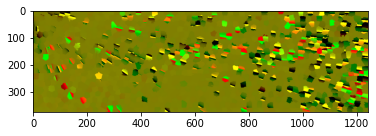

In [12]:
######################################################
## Save the "viewing" result image
######################################################
from PIL import Image

truncate = np.maximum(-255, np.minimum(255, optical_flow_graph))
truncate = ((truncate + 255)/2).astype(np.uint8)
KITTI_view = np.concatenate((truncate, np.ones(truncate.shape[:2] + (1,), dtype=truncate.dtype)), axis=2)
plt.imshow(KITTI_view)

# change to image formmat
image_output = Image.fromarray(KITTI_view)
image_output.save("KITTI_view_exp2.png")
# cv2.imwrite("./KITTI_view_exp1.png", image_output)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


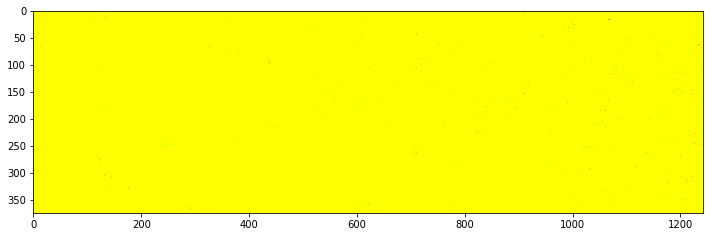

In [13]:
######################################################
## Save the "evaluation" result image
######################################################
# convert the optical_flow_graph --> evaluation format image
import numpy as np
from numpngw import write_png

image_test = optical_flow_graph

sf16 = (64*image_test[:,:,:2] + 2**15).astype(np.uint16)
imgdata = np.concatenate((sf16, np.ones(sf16.shape[:2] + (1,), dtype=sf16.dtype)), axis=2)

write_png('KITTI_evaluation_exp2.png', imgdata)

# show the imread baseline image
plt.figure(figsize=(12,12))
plt.imshow(imgdata)

In [14]:
######################################################
## Analyse the result
######################################################
img1=cv2.imread('./KITTI_view_exp1.png')
img2=cv2.imread('./000010_10.png')
 
dst=cv2.addWeighted(img1, 1, img2, 1, 0)
plt.figure(figsize=(20,20))
plt.imshow(dst)

error: ignored

### Affiliated: Debug Section

In [ ]:
for i in range(200):
  image_test = cv2.imread('./drive/MyDrive/baseline/' + str(i) + '.png')
  image_test = cv2.cvtColor(image_test, cv2.COLOR_BGR2RGB)

  sf16 = (64*image_test[:,:,:2] + 2**15).astype(np.uint16)
  imgdata = np.concatenate((sf16, np.ones(sf16.shape[:2] + (1,), dtype=sf16.dtype)), axis=2)

  write_png('drive/MyDrive/baseline_eval/' + str(i).zfill(6) + '_10.png', imgdata)

In [ ]:
import cv2

image_test = cv2.imread('./motion' + '.png')
image_test = cv2.cvtColor(image_test, cv2.COLOR_BGR2RGB)

sf16 = (64*image_test[:,:,:2] + 2**15).astype(np.uint16)
imgdata = np.concatenate((sf16, np.ones(sf16.shape[:2] + (1,), dtype=sf16.dtype)), axis=2)
write_png('./baseline_eval' + str(10).zfill(6) + '_10.png', imgdata)

In [ ]:
################################################################################
## running time analysis
################################################################################
import cProfile
import re

cProfile.run('opticalFlowSolver.solve()', "./drive/MyDrive/output_opt_ED.dat")

In [ ]:
################################################################################
## running time analysis [record]
################################################################################
import pstats

with open("./output_time.txt","w") as f:
  p = pstats.Stats("./drive/MyDrive/output_opt_ED.dat", stream=f)
  p.sort_stats("time").print_stats()